## Movie recommendation system

### Research Question: 

Can we accurately recommend movies that can bring more user engagement?


## Business Understanding

The business has an online sreaming platform that wants to increase the user engagement with platform and retains user subscription. Since there are many streaming platforms in the market, and also with in the this streaming platform there are thousands of content to choose, and it is hight chance that user can miss likable content, in other perspective, business also runs ads between videos and it is important to show more ads to get revenue. 

The goal of the business is to create a recommendation system, that can recommend movie to the user that most likely interested, and help user to find rind right content by recommending, also increase business revenue.


## Data Understanding

#### Data Collection:
The data is collected from the website called grouplens(https://grouplens.org/datasets/movielens/), GroupLens research has collected movie ratings from the MovieLens website, the data is collected thousands of movies from many users in various point of the time. The dataset describes the 5 star ratings and free-text tagging activity from MovieRlens. The users who participated in this survey are selected randomly, and all the selected users had reated at least 20 movies.

Citation:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872


#### Libraries and imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise import SlopeOne
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

#### Reading Data

In [2]:
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
print(f"Number of Rows and Colums of movies_df: {movies_df.shape}")
movies_df.head()

Number of Rows and Colums of movies_df: (9742, 3)


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [3]:
rating_df = pd.read_csv('data/ml-latest-small/ratings.csv')
print(f"Number of Rows and Colums of rating_df: {rating_df.shape}")
rating_df.head()

Number of Rows and Colums of rating_df: (100836, 4)


userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [4]:
tags_df = pd.read_csv('data/ml-latest-small/tags.csv')
print(f"Number of Rows and Colums of tags_df: {tags_df.shape}")
tags_df.head()

Number of Rows and Colums of tags_df: (3683, 4)


userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

### Data Description

The data is combination of thee datasets that are in CSV format, 
* Movies: The movies dataset contains the three features, such as, movieId, title, and genres, and having total of 9742 movies records.
* Ratings: The ratings dataset consists of 4 features, such as userId, movieId, rating and timestamp, and a staggering 100836 records. Each record is user rating for a particular movie.
* Tags: The tags dataset is having 4 features, which includes userId, movieId, tag, and timestamp, it contains total of 3683 records.

### Exploratory Data Analysis

In [5]:
# Finding number of users that are participated in ratings.
nubmer_of_users = rating_df['userId'].nunique()
print(f"Number of users provides rating : {nubmer_of_users}")

Number of users provides rating : 610


In [6]:
# Plot proportions of each rating
sns.countplot(data=rating_df, x='rating', palette='viridis')
plt.title('Count of Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [7]:
number_of_genres = movies_df['genres'].nunique()
print(f"Number of unique set of geners: {number_of_genres}")

Number of unique set of geners: 951


In [8]:
number_of_users = rating_df['userId'].nunique()
print(f"Number of users paritipated in rating: {number_of_users}")

Number of users paritipated in rating: 610


In [9]:
# plotting rating distribution per movie
rating_per_movie = rating_df.groupby('movieId')['rating'].count().reset_index()
rating_per_movie
plt.figure(figsize=(12,6))
sns.lineplot(data=rating_per_movie, x='movieId', y='rating')
plt.xlabel('Movies')
plt.ylabel('Rating Count')
plt.title('Distribution of ratings per movie')

Text(0.5, 1.0, 'Distribution of ratings per movie')

Text(0.5, 1.0, 'Distribution of ratings per user')

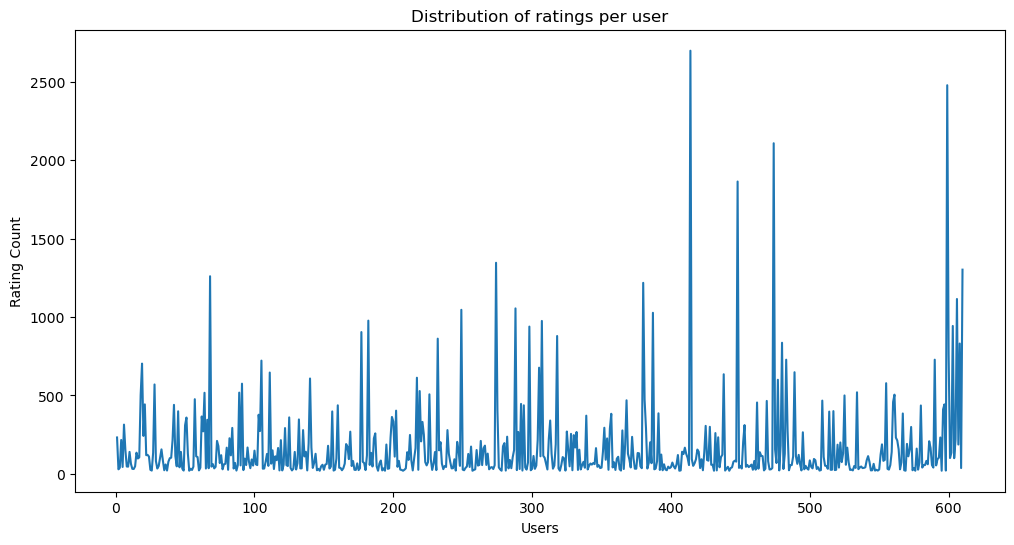

In [10]:
# Plotting rating distribution per user
rating_per_user = rating_df.groupby('userId')['rating'].count().reset_index()
rating_per_user
plt.figure(figsize=(12,6))
sns.lineplot(data=rating_per_user, x='userId', y='rating')
plt.xlabel('Users')
plt.ylabel('Rating Count')
plt.title('Distribution of ratings per user')

In [11]:
# Converting genres in to each binary column
# Create an isntance of MultilableBinarizer
mld = MultiLabelBinarizer()

# Fit and transform the data
binarized_genres = mld.fit_transform(movies_df['genres'].str.split("|"))
movies_df[mld.classes_] = binarized_genres
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  (no genres listed)  Action  \
0  Adventure|Animation|Children|Comedy|Fantasy                   0       0   
1                   Adventure|Children|Fantasy                   0       0   
2                               Comedy|Romance                   0       0   
3                         Comedy|Drama|Romance                   0       0   
4                                       Comedy                   0       0   

   Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  Horror  \
0          1          1         1       1      0  ...          0       0   
1          1          0         1       0      0  ...          0       0   
2          0          0         0       1      0  ...          0       0   
3          0          0         0       1      0  ...          0       0   
4          0          0         0       1      0  ...          0       0   

   IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0     0        0        0        0       0         0    0        0  
1     0        0        0        0       0         0    0        0  
2     0        0        0        1       0         0    0        0  
3     0        0        0        1       0         0    0        0  
4     0        0        0        0       0         0    0        0  

[5 rows x 23 columns]

In [12]:
# Plot distribution of each genres
genre_counts = movies_df.iloc[:, 3:].sum()
genre_counts.sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

In [13]:
# Finding movies that are not rated
movies_not_rated = set(movies_df['movieId']) - set(rating_df['movieId'])
movies_not_rated_df = movies_df[movies_df['movieId'].isin(movies_not_rated)]
print(f"Number of movies that are not rated: {movies_not_rated_df.shape[0]}")

Number of movies that are not rated: 18


### Verifying Data Quality

Checking any null values, because some model do not work well with null values.

In [14]:
movies_df.isnull().sum()

movieId               0
title                 0
genres                0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

In [15]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [16]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

The data is clean, all the features are formated correctly, and there no null values.

### Data Preparation

Selecting the three datasets for the modeling, first is movies_df which contains the list of movie with genres that movie belongs, and rating_df for consists of user rating for each movie, some movies are not rated, those are listed in movies_not_rated_df. Final dataset that going to be used for modeling is tags_df. Both rating and tags datasets contains the time stamp feature which is not really useful in this modeling at lest for this iteration.

In [17]:
# Droping timestamp and create new dataset
rating_df1 = rating_df.copy()
rating_df1.drop('timestamp', axis=1, inplace=True)

# Merge ratings and movies dataframe based on movieId
movie_ratings = pd.merge(rating_df1, movies_df, on='movieId')
movie_ratings

userId  movieId  rating                             title  \
0            1        1     4.0                  Toy Story (1995)   
1            5        1     4.0                  Toy Story (1995)   
2            7        1     4.5                  Toy Story (1995)   
3           15        1     2.5                  Toy Story (1995)   
4           17        1     4.5                  Toy Story (1995)   
...        ...      ...     ...                               ...   
100831     610   160341     2.5                  Bloodmoon (1997)   
100832     610   160527     4.5  Sympathy for the Underdog (1971)   
100833     610   160836     3.0                     Hazard (2005)   
100834     610   163937     3.5                Blair Witch (2016)   
100835     610   163981     3.5                         31 (2016)   

                                             genres  (no genres listed)  \
0       Adventure|Animation|Children|Comedy|Fantasy                   0   
1       Adventure|Animation|Children|Comedy|Fantasy                   0   
2       Adventure|Animation|Children|Comedy|Fantasy                   0   
3       Adventure|Animation|Children|Comedy|Fantasy                   0   
4       Adventure|Animation|Children|Comedy|Fantasy                   0   
...                                             ...                 ...   
100831                              Action|Thriller                   0   
100832                           Action|Crime|Drama                   0   
100833                        Action|Drama|Thriller                   0   
100834                              Horror|Thriller                   0   
100835                                       Horror                   0   

        Action  Adventure  Animation  Children  ...  Film-Noir  Horror  IMAX  \
0            0          1          1         1  ...          0       0     0   
1            0          1          1         1  ...          0       0     0   
2            0          1          1         1  ...          0       0     0   
3            0          1          1         1  ...          0       0     0   
4            0          1          1         1  ...          0       0     0   
...        ...        ...        ...       ...  ...        ...     ...   ...   
100831       1          0          0         0  ...          0       0     0   
100832       1          0          0         0  ...          0       0     0   
100833       1          0          0         0  ...          0       0     0   
100834       0          0          0         0  ...          0       1     0   
100835       0          0          0         0  ...          0       1     0   

        Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0             0        0        0       0         0    0        0  
1             0        0        0       0         0    0        0  
2             0        0        0       0         0    0        0  
3             0        0        0       0         0    0        0  
4             0        0        0       0         0    0        0  
...         ...      ...      ...     ...       ...  ...      ...  
100831        0        0        0       0         1    0        0  
100832        0        0        0       0         0    0        0  
100833        0        0        0       0         1    0        0  
100834        0        0        0       0         1    0        0  
100835        0        0        0       0         0    0        0  

[100836 rows x 25 columns]

### Modeling

Collaborative filtering 

In [18]:
# Loading a dataset
a = movie_ratings[['userId', 'movieId', 'rating']]
reader = Reader(rating_scale=(0,5))
sf = Dataset.load_from_df(a, reader)
print(sf)

In [19]:
# split data into train and test sets
trainset, testset = train_test_split(sf, test_size=0.25)

#### Baseline Model

In [20]:
# Baseline model create, fit and train
base_model = NormalPredictor()
base_model.fit(trainset)

# Using trained model to make predictions
base_preds = base_model.test(testset)
base_preds[:5]

[Prediction(uid=156, iid=648, r_ui=3.5, est=5, details={'was_impossible': False}),
 Prediction(uid=483, iid=46948, r_ui=4.0, est=2.6899313859290546, details={'was_impossible': False}),
 Prediction(uid=596, iid=4015, r_ui=2.0, est=2.6043282807698382, details={'was_impossible': False}),
 Prediction(uid=332, iid=26258, r_ui=2.0, est=5, details={'was_impossible': False}),
 Prediction(uid=603, iid=988, r_ui=3.0, est=1.1250992033006408, details={'was_impossible': False})]

In [21]:
mse = accuracy.mse(base_preds)
rmse = accuracy.rmse(base_preds)
print(f"Base mobel MSE: {mse} and RMSE: {rmse}")

MSE: 2.0477
RMSE: 1.4310
Base mobel MSE: 2.0476686015669308 and RMSE: 1.4309677150679994


#### SVD Model

In [22]:
# SVD model create, fit and trian.
svd = SVD(random_state=42)
svd.fit(trainset)

# Using trained model to make prediction of the testset
svd_predictions = svd.test(testset)
svd_predictions[:5]

[Prediction(uid=156, iid=648, r_ui=3.5, est=3.760419416526986, details={'was_impossible': False}),
 Prediction(uid=483, iid=46948, r_ui=4.0, est=3.3182330903194828, details={'was_impossible': False}),
 Prediction(uid=596, iid=4015, r_ui=2.0, est=2.8329091034181357, details={'was_impossible': False}),
 Prediction(uid=332, iid=26258, r_ui=2.0, est=3.3942312640823418, details={'was_impossible': False}),
 Prediction(uid=603, iid=988, r_ui=3.0, est=3.1799998986832345, details={'was_impossible': False})]

In [23]:
user = 500
movie = 1
user_rating_pred = svd.predict(user, movie).est
print(f"Predcting rating for userId: 500 and movie: 1 is : {user_rating_pred}")

condition = (movie_ratings['userId'] == 500) & (movie_ratings['movieId'] == 1)
actual_rating = movie_ratings[condition]['rating']
print(f"Actual Rating: {actual_rating.iloc[0]}")

Predcting rating for userId: 500 and movie: 1 is : 3.533555821158563
Actual Rating: 4.0


In [24]:
# predicting the movie rating that are not rated by the user
random_predict = svd.predict(190, 2).est
random_rating_check = movie_ratings[(rating_df1['userId'] == 190) & (movie_ratings['movieId'] == 2)]['rating']
print("User 190 and is not rated for movieId 2")
print(f"Rating Predication of user 190 unrated movie id 2 is: {random_predict}")

User 190 and is not rated for movieId 2
Rating Predication of user 190 unrated movie id 2 is: 3.6706164809064035


In [25]:
# Get recommendations for user
def get_recommendations(userId, model):
    movies_not_rated = trainset.build_anti_testset()
    movies_not_rated_user = [(userId, movieId, 0) for userId, movieId, _ in movies_not_rated]
    predictions = model.test(movies_not_rated_user)
    top_n = [(pred.iid, pred.est) for pred in predictions]
    top_n.sort(key=lambda x:x[1], reverse=True)
    top_10_recommendations = top_n[:10]
    return top_10_recommendations

In [26]:
# Get recommendations with mapping title
def get_recommended_movies(userId, model):
    top_10 = get_recommendations(userId, model)
    df = pd.DataFrame(top_10, columns=['movieId', 'predicted_rating'])
    df_movie_name = pd.merge(df, movies_df[['movieId', 'title']], on='movieId')
    return df_movie_name

In [27]:
# Top 10 movie recommendatioans for userId 1
print("SVD recommendations of top 10")
get_recommended_movies(1, svd)

SVD recommendations of top 10


movieId  predicted_rating                                        title
0     1193                 5       One Flew Over the Cuckoo's Nest (1975)
1     1204                 5                    Lawrence of Arabia (1962)
2    58559                 5                      Dark Knight, The (2008)
3     2700                 5  South Park: Bigger, Longer and Uncut (1999)
4      318                 5             Shawshank Redemption, The (1994)
5     2959                 5                            Fight Club (1999)
6   168252                 5                                 Logan (2017)
7     2019                 5  Seven Samurai (Shichinin no samurai) (1954)
8      904                 5                           Rear Window (1954)
9      898                 5               Philadelphia Story, The (1940)

#### SlopeOne Model

In [28]:
# Create, fit and train SlopeOne model
slope_one = SlopeOne()
slope_one.fit(trainset)
slope_one_preds = slope_one.test(testset)

slope_one_preds[:5]

[Prediction(uid=156, iid=648, r_ui=3.5, est=3.2257214262442218, details={'was_impossible': False}),
 Prediction(uid=483, iid=46948, r_ui=4.0, est=3.3696551624873097, details={'was_impossible': False}),
 Prediction(uid=596, iid=4015, r_ui=2.0, est=2.6161017278535725, details={'was_impossible': False}),
 Prediction(uid=332, iid=26258, r_ui=2.0, est=5, details={'was_impossible': False}),
 Prediction(uid=603, iid=988, r_ui=3.0, est=2.9864074600916704, details={'was_impossible': False})]

In [29]:
# top 10 movie recommendation for userId 1 using SlopeOne model
print("SlopeOne recommendation of top 10")
get_recommended_movies(1, slope_one)

SlopeOne recommendation of top 10


movieId  predicted_rating                           title
0     4226                 5                  Memento (2000)
1    26082                 5       Harakiri (Seppuku) (1962)
2     1942                 5       All the King's Men (1949)
3     6620                 5        American Splendor (2003)
4    25788                 5                 Scarface (1932)
5      356                 5             Forrest Gump (1994)
6     1204                 5       Lawrence of Arabia (1962)
7      926                 5            All About Eve (1950)
8     3851                 5  I'm the One That I Want (2000)
9   102993                 5       Way, Way Back, The (2013)

#### KNN Basic Model

In [30]:
# Create, fit and train KNN Basic model
knn = KNNBasic()
knn.fit(trainset)
knn_preds = knn.test(testset)

knn_preds[:5]

Computing the msd similarity matrix...
Done computing similarity matrix.


[Prediction(uid=156, iid=648, r_ui=3.5, est=3.5014083386936883, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=483, iid=46948, r_ui=4.0, est=2.9687465007738347, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=596, iid=4015, r_ui=2.0, est=2.8609619684776946, details={'actual_k': 26, 'was_impossible': False}),
 Prediction(uid=332, iid=26258, r_ui=2.0, est=4.469839176094566, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=603, iid=988, r_ui=3.0, est=3.0000000000000004, details={'actual_k': 1, 'was_impossible': False})]

#### GridSearchCV
Optimizing SVD hyperparameter tuning, to improve the performance of the model.

In [31]:
# defining parameter grid to search over
param_grid = {'n_factors': [10, 25, 50, 100], 'n_epochs': [5, 10, 20, 30], 'lr_all': [0.001, 0.005, 0.01, 0.1]}
svd = SVD(random_state=42)
# Instantiate GridSearchCV with the SVD algorithm and parameter grid
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mse'], cv=3)

# perform the grid search
grid_search.fit(sf)

In [32]:
# Get the best parameters and their corresponding RMSE score
print("Best Parameters:", grid_search.best_params['rmse'])
print("Best RMSE Score:", grid_search.best_score['rmse'])

Best Parameters: {'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.005}
Best RMSE Score: 0.8719138589629417


In [33]:
# create SVD with best hyperparameters
tuned_svd = SVD(n_factors=25, n_epochs=20, lr_all=0.01)
tuned_svd.fit(trainset)
tuned_svd_preds = tuned_svd.test(testset)

tuned_svd_preds[:5]

[Prediction(uid=156, iid=648, r_ui=3.5, est=3.3197976048059594, details={'was_impossible': False}),
 Prediction(uid=483, iid=46948, r_ui=4.0, est=3.1048878921515985, details={'was_impossible': False}),
 Prediction(uid=596, iid=4015, r_ui=2.0, est=2.8643247473089986, details={'was_impossible': False}),
 Prediction(uid=332, iid=26258, r_ui=2.0, est=3.851983173106365, details={'was_impossible': False}),
 Prediction(uid=603, iid=988, r_ui=3.0, est=3.2976603153373807, details={'was_impossible': False})]

#### Content based recommendation system

Content based recommendation system using TFIDFVectorizer and Cosine Similarity

In [34]:
tags_with_movie = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
tagged_movie_ratings = pd.merge(movie_ratings, tags_with_movie, how='left', on='movieId')

# merge tags with movie ratings
tagged_movie_ratings['tag'] = tagged_movie_ratings['tag'].fillna('')

# vectorization of tags using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tags_matrix = vectorizer.fit_transform(tagged_movie_ratings['tag'])

user_preferences = 'funny'

user_vector = vectorizer.transform([user_preferences])

# Calculating cosine similarity between user preferences and movies
cosine_similarities = cosine_similarity(user_vector, tags_matrix).flatten()

recommended_movies = tagged_movie_ratings[['title', 'tag']].copy()
recommended_movies['SimilarityScore'] = cosine_similarities

recommended_movies = (recommended_movies.sort_values(by='SimilarityScore', ascending=False)).drop_duplicates()

# recommending funny content
recommended_movies[['title', 'tag', 'SimilarityScore']].head(5)

title  \
89463  The Lego Batman Movie (2017)   
17230          Step Brothers (2008)   
68765               The DUFF (2015)   
57413         Big Short, The (2015)   
87997    Inside Llewyn Davis (2013)   

                                                     tag  SimilarityScore  
89463                                 funny heartwarming         0.676294  
17230  funny Highly quotable will ferrell comedy funn...         0.568249  
68765                                  funny high school         0.548529  
57413                            funny interesting Witty         0.512679  
87997        atmospheric cinematography depressing funny         0.452261

The MovieLens dataset doesn't have explicit tags for each movie, and the dataset is not structured in a way that supports effective content-based recommendation using tags

#### Evaluating the model
Evaluating the model's performance using the Mean Squared Error(MSE) and Root Mean Squared Error(RMSE).


In [35]:
# creating data frame to compare models preformance 
compare_models = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'Fit Time'])

In [36]:
# Cross validating model and return results
def model_cross_validation(model):
    cross_val_results = cross_validate(model, sf, measures=['MSE', 'RMSE'])

    mse = np.mean(cross_val_results['test_mse'], axis=0)
    rmse = np.mean(cross_val_results['test_rmse'], axis=0)
    fit_time = np.mean(cross_val_results['fit_time'], axis=0)
    return (mse, rmse, fit_time)

In [37]:
# finding and adding base model cross validatoin results to dataframe
mse, rmse, fit_time = model_cross_validation(base_model)
compare_models.loc[0] = ['Baseline', mse, rmse, fit_time]

In [38]:
# finding and adding SlopeOne model cross validatoin results to dataframe
mse, rmse, fit_time = model_cross_validation(slope_one)
compare_models.loc[1] = ['SlopeOne', mse, rmse, fit_time]

In [39]:
# finding and adding KNNBasic model cross validatoin results to dataframe
mse, rmse, fit_time = model_cross_validation(knn)
compare_models.loc[2] = ['KNNBasic', mse, rmse, fit_time]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [40]:
# finding and adding SVD model cross validatoin results to dataframe
mse, rmse, fit_time = model_cross_validation(svd)
compare_models.loc[3] = ['SVD', mse, rmse, fit_time]

In [41]:
mse, rmse, fit_time = model_cross_validation(tuned_svd)
compare_models.loc[4] = ['Tuned SVD', mse, rmse, fit_time]

In [48]:
compare_models.set_index('Model', inplace=True)
compare_models

MSE      RMSE  Fit Time
Model                                  
Baseline   2.030205  1.424841  0.083877
SlopeOne   0.813923  0.902168  3.176111
KNNBasic   0.895639  0.946371  0.076782
SVD        0.760560  0.872092  0.723550
Tuned SVD  0.764946  0.874606  0.474910

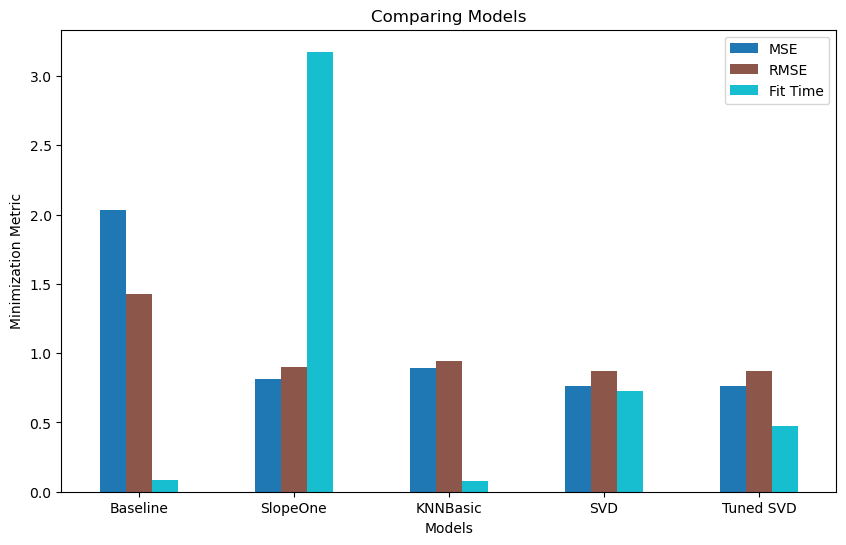

In [49]:
#compare_models.set_index('Model', inplace=True)
compare_models.plot(kind='bar', rot=0, figsize=(10, 6), colormap='tab10')
plt.title('Comparing Models')
plt.xlabel('Models')
plt.ylabel('Minimization Metric')
plt.show()

#### Selecting the best model

After comparing the all the models, such as Baseline, SlopOne, KNNBasic and SVD, the SVD with hyperperameter tuning seems to be the best choice since it has low mean square error and root mean squared error, also the less fit time.

#### Applying Model

In [44]:
# top 10 movie recommendation for userId 100 using SlopeOne model
print("Tuned SVD recommendation of top 10 for userId 100")
get_recommended_movies(100, tuned_svd)

Tuned SVD recommendation of top 10 for userId 100


movieId  predicted_rating                                         title
0     4011                 5                                 Snatch (2000)
1     4226                 5                                Memento (2000)
2      933                 5                       To Catch a Thief (1955)
3     1204                 5                     Lawrence of Arabia (1962)
4     8132                 5                              Gladiator (1992)
5     1208                 5                         Apocalypse Now (1979)
6      296                 5                           Pulp Fiction (1994)
7      318                 5              Shawshank Redemption, The (1994)
8     7361                 5  Eternal Sunshine of the Spotless Mind (2004)
9     2959                 5                             Fight Club (1999)